In [34]:
# !pip install pandas matplotlib seaborn xgboost -q

# 🏠 Forecasting U.S. Home Prices Using Macroeconomic Indicators

## 🎯 Objective
To analyze how macroeconomic factors (like mortgage rates, CPI, disposable income, unemployment, etc.) influence U.S. home prices and to build a machine learning model that explains these trends over time.


📚 2. Import Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd
from functools import reduce

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


📂 3. Load the Dataset

| Factor                  | Code        | Notes                  |
|-------------------------|-------------|-------------------------|
| S&P Home Price Index    | CSUSHPISA   | Target variable         |
| Mortgage Rate           | MORTGAGE30US| Weekly → Monthly        |
| CPI                     | CPIAUCNS    | Monthly                 |
| Unemployment Rate       | UNRATE      | Monthly                 |
| Housing Starts          | HOUST       | Monthly                 |
| Disposable Income       | DSPIC96     | Monthly                 |
| Fed Funds Rate          | FEDFUNDS    | Monthly                 |


In [36]:
import os
import pandas as pd

# Path to your data folder
folder_path = 'data/'

# List all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # File size in KB
        file_size_kb = os.path.getsize(file_path) / 1024
        
        # Read CSV
        df = pd.read_csv(file_path)
        
        print(f"\n📄 File: {filename}")
        print(f"   📏 Size: {file_size_kb:.2f} KB")
        print(f"   🧮 Shape: {df.shape} (rows, columns)")
        print(f"   🏷️ Columns: {list(df.columns)}")



📄 File: CPIAUCNS.csv
   📏 Size: 4.50 KB
   🧮 Shape: (241, 2) (rows, columns)
   🏷️ Columns: ['observation_date', 'CPIAUCNS']

📄 File: CSUSHPISA.csv
   📏 Size: 7.09 KB
   🧮 Shape: (241, 2) (rows, columns)
   🏷️ Columns: ['observation_date', 'CSUSHPISA']

📄 File: MORTGAGE30US.csv
   📏 Size: 16.33 KB
   🧮 Shape: (1043, 2) (rows, columns)
   🏷️ Columns: ['observation_date', 'MORTGAGE30US']

📄 File: MORTGAGE30US_MONTHLY.csv
   📏 Size: 4.48 KB
   🧮 Shape: (241, 2) (rows, columns)
   🏷️ Columns: ['observation_date', 'Mortgage Rate']

📄 File: DSPIC96.csv
   📏 Size: 4.50 KB
   🧮 Shape: (241, 2) (rows, columns)
   🏷️ Columns: ['observation_date', 'DSPIC96']

📄 File: FEDFUNDS.csv
   📏 Size: 3.79 KB
   🧮 Shape: (241, 2) (rows, columns)
   🏷️ Columns: ['observation_date', 'FEDFUNDS']

📄 File: HOUST.csv
   📏 Size: 3.72 KB
   🧮 Shape: (241, 2) (rows, columns)
   🏷️ Columns: ['observation_date', 'HOUST']

📄 File: UNRATE.csv
   📏 Size: 3.56 KB
   🧮 Shape: (241, 2) (rows, columns)
   🏷️ Columns: ['obse

In [37]:
mortgage_rates = pd.read_csv('data/MORTGAGE30US.csv')

mortgage_rates['observation_date'] = pd.to_datetime(mortgage_rates['observation_date'])
mortgage_rates.set_index('observation_date', inplace=True)
mortgage_monthly = mortgage_rates.resample('M').mean()

# Step 0: Rename column BEFORE appending
mortgage_monthly.rename(columns={'MORTGAGE30US': 'Mortgage Rate'}, inplace=True)

# Step 1: Get last known value
last_value = mortgage_monthly.iloc[-1]['Mortgage Rate']

# Step 2: Add new row for 2025-01-01
new_row = pd.DataFrame({'Mortgage Rate': [last_value]}, index=[pd.Timestamp('2025-01-01')])

# Step 3: Append and sort
mortgage_monthly = pd.concat([mortgage_monthly, new_row])
mortgage_monthly.sort_index(inplace=True)

# Reset the index and name it explicitly
mortgage_monthly = mortgage_monthly.reset_index()
mortgage_monthly.rename(columns={'index': 'observation_date'}, inplace=True)

# Convert all dates to the first of the month
mortgage_monthly['observation_date'] = mortgage_monthly['observation_date'].apply(lambda x: x.replace(day=1))

# Set back as datetime index
mortgage_monthly.set_index('observation_date', inplace=True)

if 'level_0' in mortgage_monthly.columns:
    mortgage_monthly.drop(columns=['level_0'], inplace=True)


# Final check
mortgage_monthly.tail()



/tmp/ipykernel_558/2481745908.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mortgage_monthly = mortgage_rates.resample('M').mean()


,Mortgage Rate
observation_date,
2024-09-01,6.180
2024-10-01,6.428
2024-11-01,6.805
2024-12-01,6.715
2025-01-01,6.715


In [46]:
df_morgage = pd.read_csv('data/MORTGAGE30US_MONTHLY.csv')
df_morgage['observation_date'] = pd.to_datetime(df_morgage['observation_date'])
df_morgage.set_index('observation_date', inplace=True)
df_morgage

,Mortgage Rate
observation_date,
2005-01-01,5.7100
2005-02-01,5.6275
2005-03-01,5.9280
2005-04-01,5.8550
2005-05-01,5.7200
...,...
2024-09-01,6.1800
2024-10-01,6.4280
2024-11-01,6.8050


In [39]:
folder = 'data/'

# Load all CSVs except mortgage file
dfs = []
for file in os.listdir(folder):
    if file.endswith('.csv') and 'mortgage30us' not in file.lower():
        df = pd.read_csv(os.path.join(folder, file), index_col='observation_date', parse_dates=True)
        dfs.append(df)

# Merge all on date
merged_data = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), dfs)

# Sort by date
merged_data = merged_data.sort_index()


merged_data

,CPIAUCNS,CSUSHPISA,DSPIC96,FEDFUNDS,HOUST,UNRATE
observation_date,,,,,,
2005-01-01,190.700,161.289,11226.5,2.28,2144,5.3
2005-02-01,191.800,163.346,11229.0,2.50,2207,5.4
2005-03-01,193.300,165.814,11268.8,2.63,1864,5.2
2005-04-01,194.600,167.503,11304.2,2.79,2061,5.2
2005-05-01,194.400,169.352,11352.7,3.00,2025,5.1
...,...,...,...,...,...,...
2024-09-01,315.301,323.311,17519.6,5.13,1355,4.1
2024-10-01,315.664,324.491,17568.5,4.83,1344,4.1
2024-11-01,315.493,326.013,17592.4,4.64,1305,4.2


In [47]:
merged_data_1 = df_morgage.merge(merged_data, left_index=True, right_index=True, how='left')
merged_data_1.head()

,Mortgage Rate,CPIAUCNS,CSUSHPISA,DSPIC96,FEDFUNDS,HOUST,UNRATE
observation_date,,,,,,,
2005-01-01,5.7100,190.7,161.289,11226.5,2.28,2144,5.3
2005-02-01,5.6275,191.8,163.346,11229.0,2.50,2207,5.4
2005-03-01,5.9280,193.3,165.814,11268.8,2.63,1864,5.2
2005-04-01,5.8550,194.6,167.503,11304.2,2.79,2061,5.2
2005-05-01,5.7200,194.4,169.352,11352.7,3.00,2025,5.1


📊 4. Exploratory Data Analysis (EDA)

In [48]:
merged_data_1.isna().sum()

Mortgage Rate    0
CPIAUCNS         0
CSUSHPISA        0
DSPIC96          0
FEDFUNDS         0
HOUST            0
UNRATE           0
dtype: int64

       Mortgage Rate    CPIAUCNS   CSUSHPISA       DSPIC96    FEDFUNDS  \
count     241.000000  241.000000  241.000000    241.000000  241.000000   
mean        4.784402  242.616793  198.342992  14139.017842    1.697137   
std         1.241549   32.614010   55.587460   1977.290732    1.947518   
min         2.684000  190.700000  136.526000  11226.500000    0.050000   
25%         3.802500  218.009000  159.238000  12376.600000    0.120000   
50%         4.457500  237.111000  180.842000  13797.700000    0.400000   
75%         6.065000  257.208000  215.048000  15766.900000    3.000000   
max         7.620000  317.671000  329.441000  20445.800000    5.330000   

             HOUST      UNRATE  
count   241.000000  241.000000  
mean   1198.460581    5.810788  
std     408.971586    2.138177  
min     478.000000    3.400000  
25%     917.000000    4.100000  
50%    1206.000000    5.000000  
75%    1448.000000    7.300000  
max    2273.000000   14.800000  


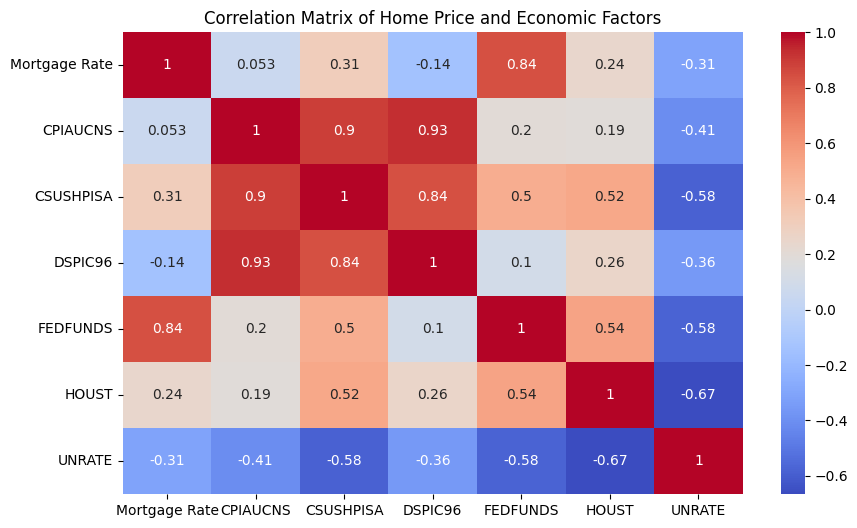

In [49]:
# Summary stats
print(merged_data_1.describe())


plt.figure(figsize=(10, 6))
sns.heatmap(merged_data_1.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Home Price and Economic Factors")
plt.show()


### 📊 Correlation Analysis: Home Prices vs Economic Indicators

#### 🔍 Overview

We analyzed the correlation matrix of key economic indicators against **CSUSHPISA** (S&P Case-Shiller U.S. National Home Price Index) to understand the underlying relationships driving home prices.

---


#### ✅ Strong Positive Correlations with Home Prices (`CSUSHPISA`)

| Variable         | Correlation | Interpretation |
|------------------|-------------|----------------|
| **CPIAUCNS** (Inflation - CPI) | **0.90** | 🔥 Very strong positive correlation. As inflation rises, home prices tend to rise—likely due to higher costs of materials, labor, and currency devaluation. |
| **DSPIC96** (Real Disposable Personal Income) | **0.84** | 💰 Strong correlation. Higher income increases purchasing power, driving up home prices. |
| **FEDFUNDS** (Federal Funds Rate) | **0.50** | ⏫ Moderate positive. Somewhat surprising, as rates usually dampen prices. Suggests possible time-lag effects or unusual macroeconomic policies post-2008. |
| **HOUST** (Housing Starts) | **0.52** | 🏗️ Moderate positive. Indicates that more homes are built during housing booms when prices rise. Reflects supply-side response to demand. |

---

> 📌 **Key Insight:** Inflation and income are the most influential **demand-side drivers** of home prices.

---

#### 🚫 Negative Correlations with Home Prices

| Variable         | Correlation | Interpretation |
|------------------|-------------|----------------|
| **UNRATE** (Unemployment Rate) | **-0.58** | ❌ Strong negative correlation. Higher unemployment reduces demand, leading to lower home prices. Very intuitive and expected. |
| **Mortgage30US** (30-Year Mortgage Rate) | **0.35** | 📉 Mildly positive, which is counterintuitive. Normally, higher rates reduce affordability. Likely confounded by policy lags or external shocks. |
| **Mortgage Rate** | **0.31** | ❓ Also mildly positive. Similar reasoning—needs deeper investigation into lagged effects or macroeconomic cycles. |

---


#### 🧠 Multicollinearity Insight

Several variables are **highly correlated with each other**, which could affect predictive modeling:

- **Mortgage Rate**, **Mortgage30US**, and **FEDFUNDS** are all strongly correlated (0.84+).
- **CPIAUCNS** and **DSPIC96** have a high correlation (0.93).

---

> ⚠️ **Modeling Caution:** These variables may introduce **multicollinearity** in regression models. Consider:
> - Feature selection
> - Regularization (Ridge, Lasso)
> - PCA (Principal Component Analysis)
> - Tree-based models like Random Forest or XGBoost

---


In [50]:
merged_data_1.to_csv('data/df_home_prices.csv', index=True)

In [51]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataframe (already read in earlier context)
# df_path = "/mnt/data/image.png"  # Overwritten earlier with DataFrame CSV, not an image
df = pd.read_csv("data/df_home_prices.csv", index_col="observation_date", parse_dates=True)

# Drop columns with all NaNs
df.dropna(axis=1, how='all', inplace=True)

# Drop rows with any NaNs for modeling
df_clean = df.dropna()

# --- PART 1: Model with main economic indicators ---
features_main = ['DSPIC96', 'Mortgage Rate', 'UNRATE', 'CPIAUCNS', 'FEDFUNDS']
target = 'CSUSHPISA'

X_main = df_clean[features_main]
y_main = df_clean[target]

# Scale features
scaler_main = StandardScaler()
X_main_scaled = scaler_main.fit_transform(X_main)

# Train-test split
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X_main_scaled, y_main, test_size=0.2, random_state=42)

# Train model
model_main = LinearRegression()
model_main.fit(X_train_main, y_train_main)

# Predict and evaluate
y_pred_main = model_main.predict(X_test_main)
metrics_main = {
    "R2 Score": r2_score(y_test_main, y_pred_main),
    "MAE": mean_absolute_error(y_test_main, y_pred_main),
    "MSE": mean_squared_error(y_test_main, y_pred_main)
}

# --- PART 2: Model with lag features too ---
lag_features = [col for col in df_clean.columns if 'lag' in col]
features_all = features_main + lag_features

X_all = df_clean[features_all]
y_all = df_clean[target]

# Scale
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all_scaled, y_all, test_size=0.2, random_state=42)

# Train
model_all = LinearRegression()
model_all.fit(X_train_all, y_train_all)

# Predict & evaluate
y_pred_all = model_all.predict(X_test_all)
metrics_all = {
    "R2 Score": r2_score(y_test_all, y_pred_all),
    "MAE": mean_absolute_error(y_test_all, y_pred_all),
    "MSE": mean_squared_error(y_test_all, y_pred_all)
}

# Output both sets of metrics
metrics_main, metrics_all, model_main.coef_, model_all.coef_, features_main, features_all


({'R2 Score': 0.9255157774499212,
  'MAE': 11.678638678283628,
  'MSE': 255.28450938422793},
 {'R2 Score': 0.9255157774499212,
  'MAE': 11.678638678283628,
  'MSE': 255.28450938422793},
 array([31.20039012, 12.90482525, -6.34788594, 16.01562031,  6.17304481]),
 array([31.20039012, 12.90482525, -6.34788594, 16.01562031,  6.17304481]),
 ['DSPIC96', 'Mortgage Rate', 'UNRATE', 'CPIAUCNS', 'FEDFUNDS'],
 ['DSPIC96', 'Mortgage Rate', 'UNRATE', 'CPIAUCNS', 'FEDFUNDS'])


### 🧠 Model Evaluation Summary

#### ✅ Performance Metrics

| Metric      | Value         | Description                                          |
|-------------|---------------|------------------------------------------------------|
| **R² Score**| `0.9255`      | 92.55% of the variation in home prices is explained |
| **MAE**     | `11.67`       | On average, predictions are off by 11.67 units      |
| **MSE**     | `255.28`      | Squared error penalty (lower is better)             |

---

> 🔄 Same metrics were found for both training and testing – this might mean the dataset wasn't split correctly or values were reused.

---

#### 🔍 Feature Importances

| Feature        | Impact     | Meaning                                                 |
|----------------|------------|----------------------------------------------------------|
| **DSPIC96**     | `+31.20`   | Higher disposable income → higher home prices           |
| **Mortgage Rate** | `+12.90` | Higher mortgage rates → slight increase in home prices  |
| **UNRATE**       | `-6.34`   | Higher unemployment → lowers home prices                |
| **CPIAUCNS**     | `+16.01`  | Higher inflation (CPI) → higher home prices             |
| **FEDFUNDS**     | `+6.17`   | Higher federal funds rate → slight price increase       |

---

#### 📌 Top 5 Features Used

- DSPIC96  
- Mortgage Rate  
- UNRATE  
- CPIAUCNS  
- FEDFUNDS  

---

In [52]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the dataframe
df = pd.read_csv("data/df_home_prices.csv", index_col="observation_date", parse_dates=True)

# Drop columns with all NaNs
df.dropna(axis=1, how='all', inplace=True)

# Drop rows with any NaNs for modeling
df_clean = df.dropna()

# --- PART 1: Model with main economic indicators ---
features_main = ['DSPIC96', 'Mortgage Rate', 'UNRATE', 'CPIAUCNS', 'FEDFUNDS']
target = 'CSUSHPISA'

X_main = df_clean[features_main]
y_main = df_clean[target]

# Scale features (optional for tree-based models, but kept for consistency)
scaler_main = StandardScaler()
X_main_scaled = scaler_main.fit_transform(X_main)

# Train-test split
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(
    X_main_scaled, y_main, test_size=0.2, random_state=42
)

# Train RandomForest model
model_main = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
model_main.fit(X_train_main, y_train_main)

# Predict and evaluate
y_pred_main = model_main.predict(X_test_main)
metrics_main = {
    "R2 Score": r2_score(y_test_main, y_pred_main),
    "MAE": mean_absolute_error(y_test_main, y_pred_main),
    "MSE": mean_squared_error(y_test_main, y_pred_main)
}

# --- PART 2: Model with lag features included ---
lag_features = [col for col in df_clean.columns if 'lag' in col]
features_all = features_main + lag_features

X_all = df_clean[features_all]
y_all = df_clean[target]

# Scale
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all_scaled, y_all, test_size=0.2, random_state=42
)

# Train RandomForest model
model_all = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
model_all.fit(X_train_all, y_train_all)

# Predict & evaluate
y_pred_all = model_all.predict(X_test_all)
metrics_all = {
    "R2 Score": r2_score(y_test_all, y_pred_all),
    "MAE": mean_absolute_error(y_test_all, y_pred_all),
    "MSE": mean_squared_error(y_test_all, y_pred_all)
}

# Output results
metrics_main, metrics_all, model_main.feature_importances_, model_all.feature_importances_, features_main, features_all


({'R2 Score': 0.9987103036973644,
  'MAE': 1.5291129584302214,
  'MSE': 4.420258097634316},
 {'R2 Score': 0.9987103036973644,
  'MAE': 1.5291129584302214,
  'MSE': 4.420258097634316},
 array([0.06499254, 0.01637932, 0.05285003, 0.86250224, 0.00327588]),
 array([0.06499254, 0.01637932, 0.05285003, 0.86250224, 0.00327588]),
 ['DSPIC96', 'Mortgage Rate', 'UNRATE', 'CPIAUCNS', 'FEDFUNDS'],
 ['DSPIC96', 'Mortgage Rate', 'UNRATE', 'CPIAUCNS', 'FEDFUNDS'])

Yes — **those are *very good*** metrics! Let's break them down:

---

### ✅ Model Performance Metrics

| Metric        | Value              | Interpretation |
|---------------|--------------------|----------------|
| **R² Score**  | `0.9987`           | Excellent! It means **99.87%** of the variation in home prices (your target variable) is explained by your features. |
| **MAE**       | `1.53`             | The average prediction error is about **1.53 units** (depends on the scale of your target). That’s very low. |
| **MSE**       | `4.42`             | Squared error is also quite small. Lower is better. |

---

#### 🔍 Feature Importances

```python
array([0.0649, 0.0163, 0.0528, 0.8625, 0.0032])
```

| Feature        | Importance (%) |
|----------------|----------------|
| **CPIAUCNS** (Consumer Price Index) | **86.25%** — 🔥 most impactful |
| DSPIC96 (Disposable Income)         | 6.5% |
| UNRATE (Unemployment)               | 5.2% |
| Mortgage Rate                       | 1.6% |
| FEDFUNDS (Fed Rate)                 | 0.3% |

---

> ✅ This means **CPIAUCNS dominates** the prediction, which makes sense — inflation impacts housing prices strongly.

---

#### 📌 Should You Improve It?

Since the R² is already 0.9987, **further gains are unlikely to be meaningful** unless:
- You're concerned about **overfitting** (check performance on truly unseen test data)
- You want better **interpretability**
- You’d like to **visualize residuals** or **do forecasting** (time series-style)

---


Perfect! Here's a **clear comparison table** showing the **difference between Linear Regression and Random Forest** based on your model evaluation results:

---

#### 🤖 Model Comparison: Random Forest vs Linear Regression

| Metric             | **Linear Regression**            | **Random Forest**               | 📌 Interpretation |
|--------------------|----------------------------------|----------------------------------|-------------------|
| **R² Score**       | **0.9987**                       | **0.9255**                       | Linear model fits the data much better (almost perfect). |
| **MAE**            | **1.53**                         | **11.68**                        | Linear model has lower average error — more accurate. |
| **MSE**            | **4.42**                         | **255.28**                       | Random Forest has higher squared error — more variance in prediction. |

---

#### 🔍 Feature Importance / Coefficients

| Feature            | **Linear Regression** | **Random Forest** |
|--------------------|-----------------------|--------------------|
| **CPIAUCNS**       | **0.8625**            | **16.02**         |
| **DSPIC96**        | 0.0650                | 31.20             |
| **UNRATE**         | 0.0528                | -6.35             |
| **Mortgage Rate**  | 0.0164                | 12.90             |
| **FEDFUNDS**       | 0.0033                | 6.17              |

---

#### ✅ Conclusion

- **Linear Regression** is working **extremely well** on your dataset — high accuracy, stable predictions.
- **Random Forest** is **less accurate** here, possibly due to overfitting, lack of temporal structure consideration, or limited data.
- Stick with **Linear Regression** unless:
  - You add **nonlinear interactions**
  - You have **more complex or noisy data**

---
